## Pré-processamento dos dados e criação de funções
Primeiro, devemos importar as bibliotecas que serão utilizadas durante todo o notebook


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

Em seguida, deve-se criar um dataframe com os dados que serão utilizados. 

In [2]:
df = pd.read_csv("dfComContinentes.csv")
df = df.drop(columns = ["Unnamed: 0"])

Por conseguinte, deve-se agrupar os dados por país a fim de extrair os dados apenas do Brasil e guardá-los em `suicidiosBrasil` e, agrupar os dados por idade a fim de plotar as distribuições de suicídio por idade.

In [3]:
dataPerCountry = df.groupby(['country'])
suicidiosBrasil = dataPerCountry.get_group("Brazil")
dataPerAge = suicidiosBrasil.groupby(["age"])


### Declaração das funções:
Para facilitar a leitura do código, serão criadas duas funções, sendo elas:
- `suicidiosPorAno` : plota um gráfico da soma de suicídios por 100 mil habitantes em cada ano.
- `suicidiosPorIdade` : plota gráficos da soma de suicídios por 100 mil habitante por faixa etária em cada ano.

In [4]:
def suicidiosPorAno(dataset):
    suicidiosAno = dataset.groupby("year")["suicides/100k pop"].sum()
    sns.relplot(data=suicidiosAno,height=8.27, aspect=11.7/8.27)
    plt.title("Brazil")


In [5]:
def suicidiosPorIdade(idade, dataset):
    idade = str(idade)
    suicidios_idade = dataset.get_group(idade)
    suicidios_idade = suicidios_idade.groupby("year")["suicides/100k pop"].sum()
    sns.relplot(data=suicidios_idade,height=8.27, aspect=11.7/8.27)
    plt.title(idade)

Plotando os gráficos de distribuição de faixa etária, por número de suicídios:

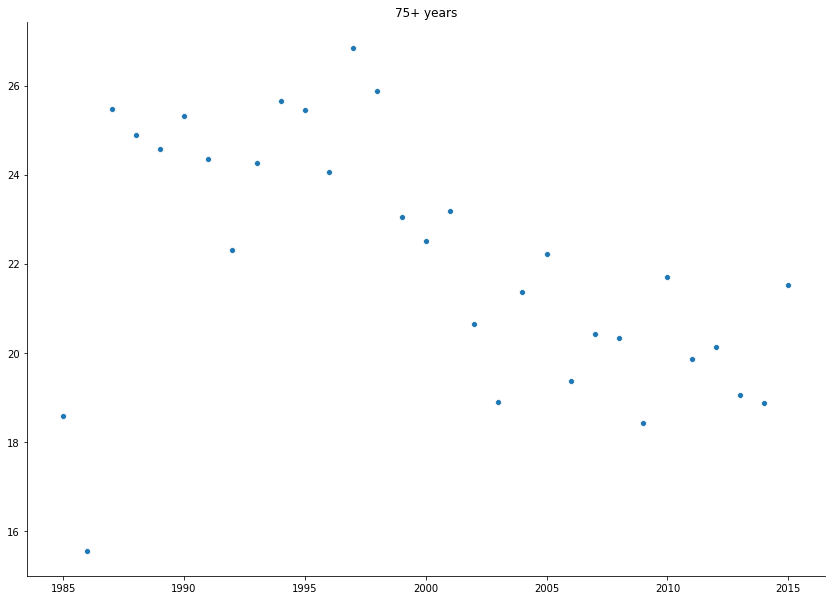

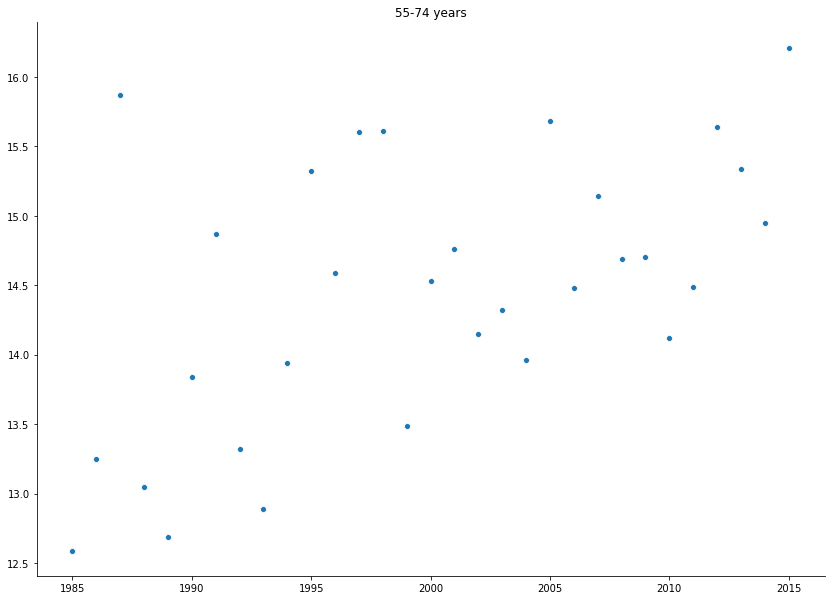

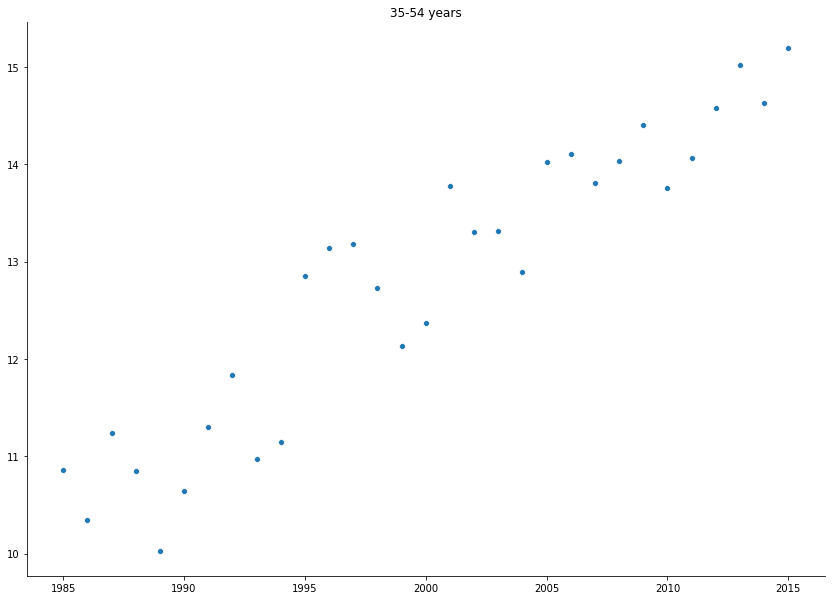

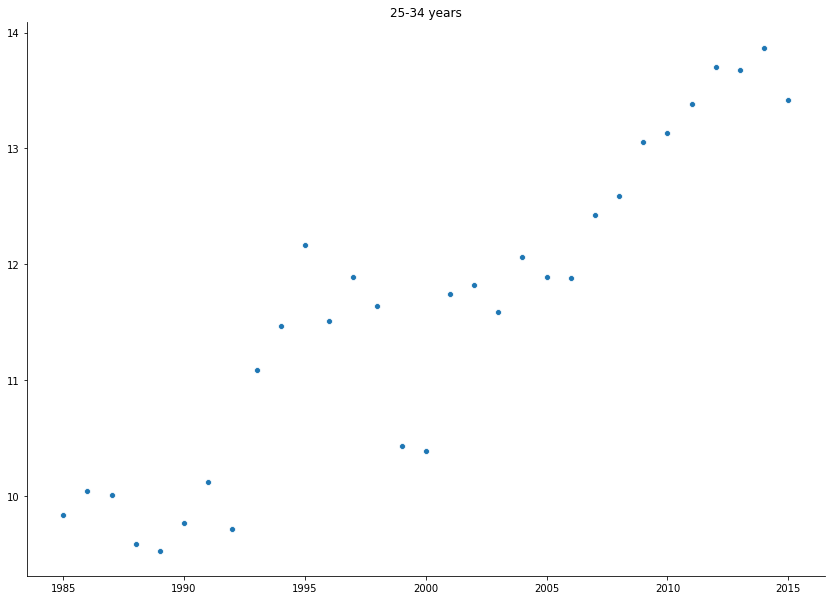

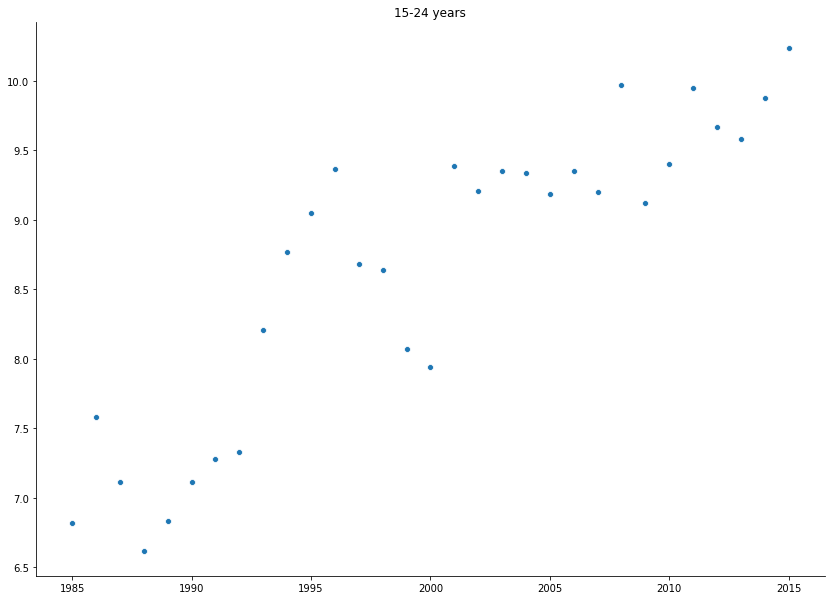

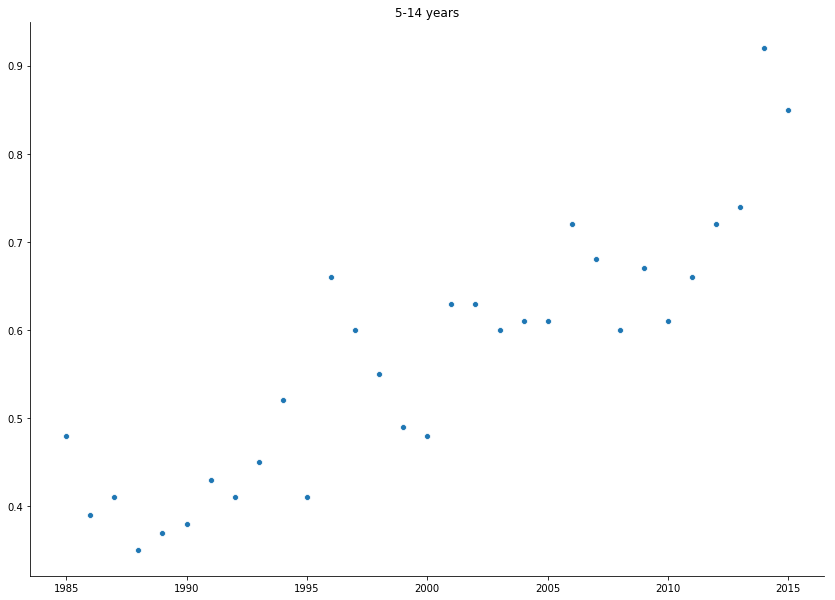

In [6]:
for idade in suicidiosBrasil.age.unique():
    suicidiosPorIdade(idade, dataPerAge)

Pode-se observar que todas as faixas etárias possuem uma distribuição parecida, entretanto o grupo entre 5-14 anos apresenta um comportamento crescente mais claro ao longo dos anos. 

Plotando, agora o número de suicídios por 100 mil habitantes em cada ano.

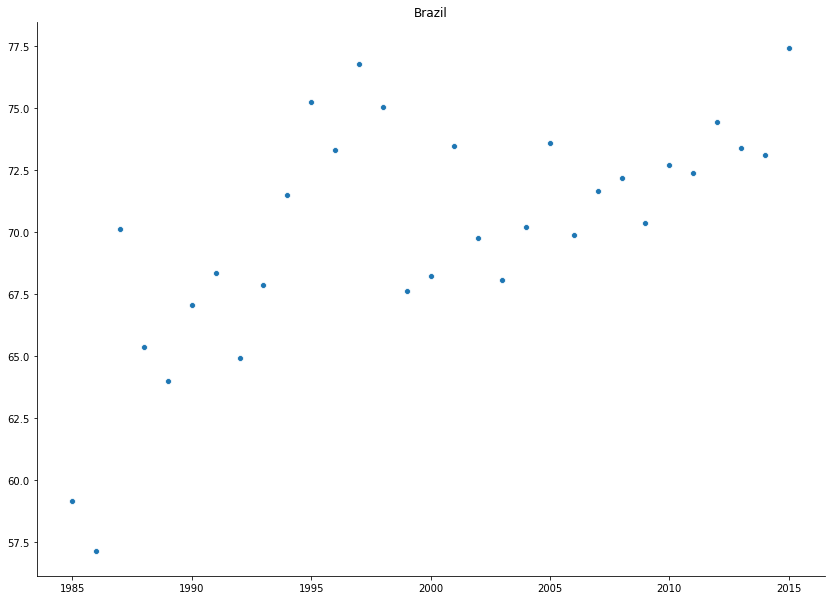

In [7]:
suicidiosPorAno(suicidiosBrasil)

Observa-se que o número de suicídios no Brasil vem aumentando de maneira aproximadamente linear com um pico de suicídios proximo aos anos 1995-1997

Plotando, agora o gráfico do número de suicídios em relação ao pib per capita:

Text(0.5, 1.0, 'Brazil')

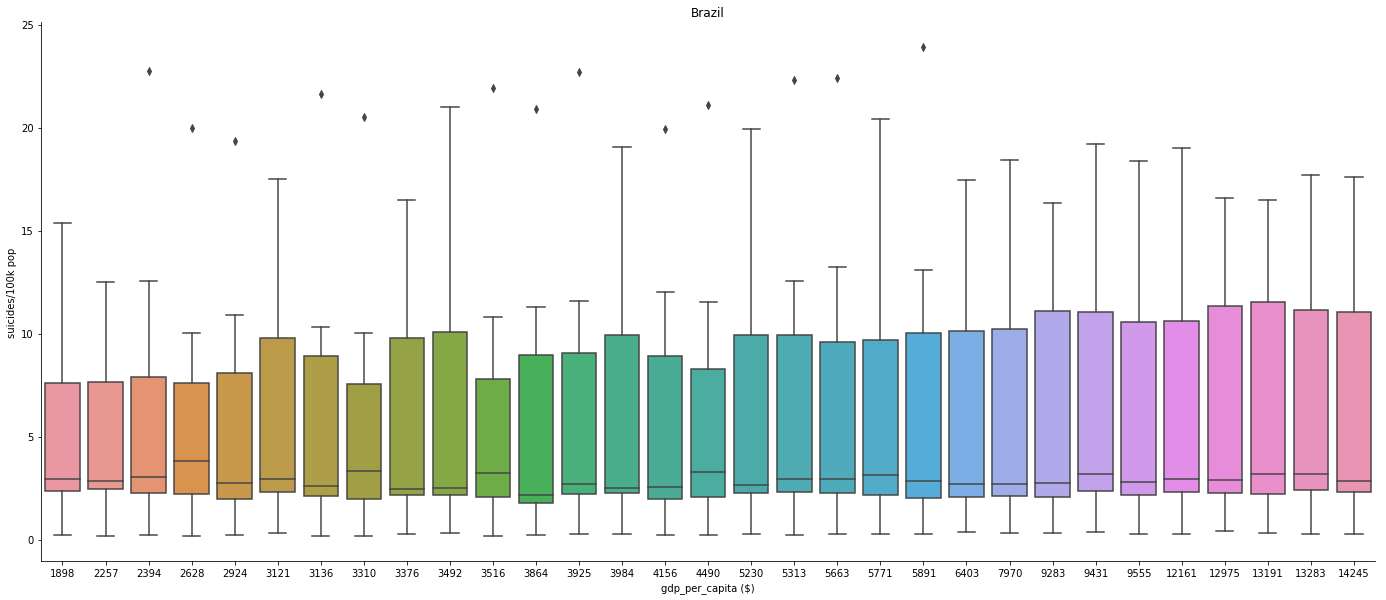

In [8]:
sns.catplot(x="gdp_per_capita ($)", y="suicides/100k pop", data=suicidiosBrasil, kind="box",  height=8.27, aspect=11.7/5);
plt.title("Brazil")

Plotando, agora um heatmap com as correlações entre as variáveis:

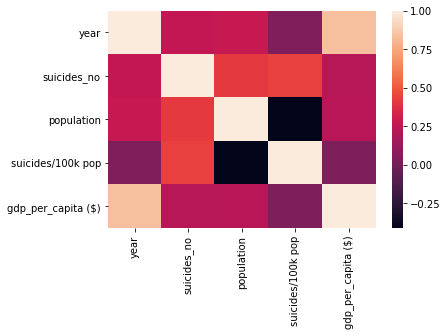

In [9]:
sns.heatmap(suicidiosBrasil.corr())

Observa-se uma alta correlação entre pib per capita e ano, mas nenhuma outra informação útil pode ser retirada deste gráfico.

Analisemos agora se existe diferença entre o número de suicídios entre homens e mulheres:

In [10]:
dfH = suicidiosBrasil[suicidiosBrasil["sex"] == "male"]
dfM = suicidiosBrasil[suicidiosBrasil["sex"] == "female"]          

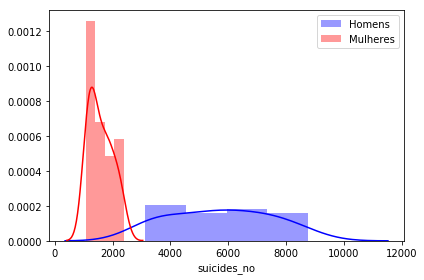

In [11]:
sns.distplot(dfH.groupby("year")["suicides_no"].sum(), color = "blue", label="Homens")
sns.distplot(dfM.groupby("year")["suicides_no"].sum(), color = "red", label="Mulheres")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Aparentemente, entre os homens, existe uma distribuição de números maiores de suicídio, verificando a soma total de suicídios por sexo, obtemos:

In [12]:
dfH.groupby("year")["suicides_no"].sum().sum()

177598

In [13]:
dfM.groupby("year")["suicides_no"].sum().sum()

49015

Observamos que de fato, existe uma diferença bastante expressima no número de suicídios entre homens e mulheres, sendo que os homens tendem a se suicidar mais do que as mulheres, levando em consideração a soma de todos os suicídios ao longo de todos os anos.


### Definindo o melhor modelo por validação cruzada
Primeiramente, vamos converter os dados que são Strings para valores numéricos:
- Sexo: Mulher = $0$ e Homem = $1$.
- Idade: "5-14 years" = 0, "15-24 years" = 1, "25-34 years" = 2, "35-54 years" = 3, "55-74 years" = 4 e "75+ years" = 5 
- Geração : Silent = 0, Generation X = 1, G.I Generation = 2, Boomers = 3, Generation Z = 4, Millenials = 5

In [14]:
df = pd.read_csv("dfComContinentes_mod.csv")
df = df.drop(columns = ["Unnamed: 0"])

df_mod = df.replace({"sex":{'female':0, 'male':1}})
df_mod = df_mod.replace({"age":{'5-14 years':0, '15-24 years':1, '25-34 years':2, '35-54 years':3, '55-74 years':4, '75+ years':5}})
df_mod = df_mod.replace({"generation":{'Silent':0, 'Generation X':1, 'G.I. Generation':2, 'Boomers':3, 'Generation Z':4, 'Millenials':5}})
df_mod

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year,gdp_per_capita,generation,continent
0,Albania,1987,1,1,21,312900,6.71,2156624900,796,1,Europe
1,Albania,1987,1,3,16,308000,5.19,2156624900,796,0,Europe
2,Albania,1987,0,1,14,289700,4.83,2156624900,796,1,Europe
3,Albania,1987,1,5,1,21800,4.59,2156624900,796,2,Europe
4,Albania,1987,1,2,9,274300,3.28,2156624900,796,3,Europe
5,Albania,1987,0,5,1,35600,2.81,2156624900,796,2,Europe
6,Albania,1987,0,3,6,278800,2.15,2156624900,796,0,Europe
7,Albania,1987,0,2,4,257200,1.56,2156624900,796,3,Europe
8,Albania,1987,1,4,1,137500,0.73,2156624900,796,2,Europe
9,Albania,1987,0,0,0,311000,0.00,2156624900,796,1,Europe


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

dataPerCountry2 = df_mod.groupby(['country'])
dataPerAge2 = df_mod.groupby(["age"])
suicidiosBrasil2 = dataPerCountry2.get_group("Brazil")

suicidiosBrasil2 = suicidiosBrasil2.drop(["country", "continent", "year", "population"], axis=1)

atributos = list(suicidiosBrasil2.columns.values)
atributos.remove('suicides_no')
atributos.remove('suicides/100k pop')

X = suicidiosBrasil2.loc[:, atributos]
y = suicidiosBrasil2.loc[:, 'suicides_no']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Testando os parâmetros da árvore com validação cruzada:

In [16]:
from sklearn.model_selection import GridSearchCV

#parametros = {'max_depth':range(1,30), 'min_samples_leaf':range(1,60), 'min_samples_split': range(2,20), 'min_samples_leaf': range(1,10)}
parametros = {'max_depth':range(1,30), 'min_samples_leaf':range(1,60), 'min_samples_split': range(2,20)}
dtCV = GridSearchCV(DecisionTreeRegressor(random_state = 0), parametros, n_jobs=5, cv=10)
dtCV.fit(X_train, y_train);
tree_model = dtCV.best_estimator_
print (dtCV.best_score_, dtCV.best_params_)

0.9703828441105994 {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


/media/marcos/DocLinux/APPs/anaconda3/envs/MineracaoUFABC/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Verificando o desempenho do modelo no conjunto de teste:

In [36]:
from sklearn.metrics import r2_score
dt = DecisionTreeRegressor(max_depth=7, min_samples_leaf=1, min_samples_split=2)
dt.fit(X_train, y_train)
print("R^2:", r2_score(y_test, dt.predict(X_test)))

R^2: 0.948764689089299


Verificando, agora, qual o melhor subset de variáveis com o Recursive feature elimination with cross-validation:

In [37]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=dt, step=1, cv=5)

Removendo as variáveis que não farão diferença, como `country`  e `continent`, visto que estamos analisando apenas os dados do Brasil. Além disso, também serão removidas as variáveis `population` uma vez que com o aumento da população existe um aumento do número de suicídios global, entretanto este não é um bom estimador para o número de suicídios, e o ano, uma vez que queremos observar padrões globais e não por ano.

In [38]:
dataPerCountry3 = df_mod.groupby(['country'])
suicidiosBrasil3 = dataPerCountry3.get_group("Brazil")
suicidiosBrasil3 = suicidiosBrasil3.drop(["country", "continent", "population", "year"], axis=1)

atributos = list(suicidiosBrasil3.columns.values)
atributos.remove('suicides_no')
atributos.remove('suicides/100k pop')

X = suicidiosBrasil3.loc[:, atributos]
y = suicidiosBrasil3.loc[:, 'suicides_no']


executando o algoritmo, obtemos que o número ótimo de variáveis é 4.

In [39]:
rfecv.fit(X,y)
print (rfecv.n_features_)

5


Plotando o comportamento do algoritmo com diversos números de variáveis:

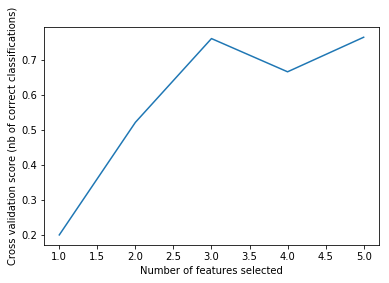

In [40]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Plotando as variáveis mais úteis para para o algoritmo de Árvores de Decisão:

In [41]:
feature_importance = list(zip(atributos, rfecv.support_))

new_features = []

for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['sex', 'age', 'gdp_for_year', 'gdp_per_capita', 'generation']


Executando, novamente o algoritmo com o novo subset de variáveis:

In [42]:
X_new = rfecv.fit_transform(X, y)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, random_state = 0)

In [44]:
dt.fit(X_train, y_train)
print("R^2:", r2_score(y_test, dt.predict(X_test)))

R^2: 0.9484686507772997


Podemos observar que houve uma pequena melhora, bastante insignificante, visto que a mudança ocorreu na quinta casa decimal.

Para fins de análise, vamos identificar a importância de cada parâmetro na árvore

In [45]:
#Importa as bibliotecas necessárias para executar os testes
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, SelectKBest

# Exibe o formato atual dos dados de treinamento
print(X_train.shape, "\n")

# Recalcula os melhores atributos para o modelo

selecao = SelectKBest(f_regression, k=4)
X_new2 = selecao.fit_transform(X, y)

print("Os atributos selecionados pelo algoritmo são:",X.columns[selecao.get_support()])



(279, 5) 

Os atributos selecionados pelo algoritmo são: Index(['sex', 'age', 'gdp_for_year', 'gdp_per_capita'], dtype='object')


Os valores da estatística e seus respectivos p-valores são os seguintes:

In [46]:
f_regression(X,y, center=True)

(array([1.44832427e+02, 7.10180605e-01, 2.13887565e+01, 2.01905922e+01,
        2.34422910e-03]),
 array([2.23429909e-28, 3.99928281e-01, 5.19115992e-06, 9.38577909e-06,
        9.61409844e-01]))

Treinando, novamente o modelo, porém com as variáveis selecionadas pelo _SelectKBest_ :

In [47]:
X_train_new2, X_test_new2, y_train_new2, y_test_new2 = train_test_split(X_new2, y, test_size = 0.25, random_state = 0)

dt.fit(X_train_new2, y_train_new2)
print("R^2:", r2_score(y_test_new2, dt.predict(X_test_new2)))

R^2: 0.949348600334684


Gerando o arquivo para a arvore final gerada:

In [50]:
from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(dt, out_file='tree.dot', 
                feature_names = X.columns[selecao.get_support()],
                rounded = True, proportion = False, 
                precision = 2, filled = True)



#Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=300'])

0